In [82]:
import pandas as pd
import numpy as np

In [83]:
df = pd.read_csv('feeds.csv')

In [84]:
df.dropna()

,id,source_id,title,description,link,category,image,big_image,connecting,published_at,created_at,updated_at,reaction_count,comment_count,share_count
495,496,1,"Rosszul lett a győri állatkert elefántja, tűzo...",Egy vers is született a mentésről.,https://index.hu/belfold/2023/07/25/gyor-tuzol...,belföld,https://kep.index.hu/1/0/5006/50065/500657/500...,https://kep.index.hu/1/0/5006/50065/500657/500...,482,2023-07-25 19:11:00,2023-07-25 19:15:03,2023-07-25 23:24:15,321.0,31.0,13.0
639,640,1,Ítélet született a 2016-os brüsszeli terrortám...,A támadásoknak 32 halálos áldozata volt.,https://index.hu/kulfold/2023/07/25/brusszel-i...,külföld,https://kep.index.hu/1/0/5006/50066/500662/500...,https://kep.index.hu/1/0/5006/50066/500662/500...,665,2023-07-25 21:18:00,2023-07-25 21:25:03,2023-07-26 06:20:01,0.0,0.0,1.0
735,736,1,Egy hete nem működik a Belügyminisztérium közi...,Hadházy Ákos szerint nem véletlenül.,https://index.hu/belfold/2023/07/26/belugymini...,belföld,https://kep.index.hu/1/0/5006/50066/500665/500...,https://kep.index.hu/1/0/5006/50066/500665/500...,678,2023-07-26 06:02:00,2023-07-26 06:05:02,2023-07-26 16:48:21,15.0,1.0,31.0
736,737,1,Piszkos bombákkal és tömegpusztító fegyverekke...,A szakértők megosztottak ebben a kérdésben.,https://index.hu/kulfold/2023/07/26/haboru-oro...,külföld,https://kep.index.hu/1/0/5006/50066/500664/500...,https://kep.index.hu/1/0/5006/50066/500664/500...,804,2023-07-26 06:02:00,2023-07-26 06:05:02,2023-07-26 21:48:10,61.0,84.0,15.0
737,738,1,Egy 19 éves fiúnál diagnosztizálták az Alzheim...,"Ő valaha volt legfiatalabb, akinél megállapíto...",https://index.hu/tudomany/2023/07/26/legfiatal...,tudomány,https://kep.index.hu/1/0/5006/50065/500656/500...,https://kep.index.hu/1/0/5006/50065/500656/500...,786,2023-07-26 06:00:00,2023-07-26 06:05:02,2023-07-26 17:36:26,11.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17618,17619,1,Korábban érkezik a családtámogatás,Nemsokára utal az államkincstár.,https://index.hu/belfold/2023/08/10/kulturalis...,belföld,https://kep.index.hu/1/0/5037/50371/503718/503...,https://kep.index.hu/1/0/5037/50371/503718/503...,17728,2023-08-10 12:42:00,2023-08-10 12:45:03,2023-08-10 16:48:05,0.0,0.0,20.0
17688,17689,1,„Kivégzés” a futballpályán: repülve rúgta fejb...,Mi volt a cél?,https://index.hu/sport/futball/2023/08/10/-kiv...,futball,https://kep.index.hu/1/0/5037/50374/503741/503...,https://kep.index.hu/1/0/5037/50374/503741/503...,17772,2023-08-10 13:34:00,2023-08-10 13:35:03,2023-08-10 16:36:31,12.0,1.0,4.0
17690,17691,1,Már több mint 13 milliárd forintnál tart a Mag...,És még nincs vége… De nincsenek jogi konzekven...,https://index.hu/sport/tenisz/2023/08/10/tenis...,tenisz,https://kep.index.hu/1/0/5034/50344/503444/503...,https://kep.index.hu/1/0/5034/50344/503444/503...,17756,2023-08-10 13:28:00,2023-08-10 13:35:03,2023-08-10 14:30:02,0.0,0.0,0.0
17747,17748,1,Krausz Gábor kiköltözött Tóth Gabival közös ál...,Gyorsan haladnak az események.,https://index.hu/fomo/2023/08/10/toth-gabi-kra...,fomo,https://kep.index.hu/1/0/5037/50374/503744/503...,https://kep.index.hu/1/0/5037/50374/503744/503...,"17817,17746",2023-08-10 14:14:00,2023-08-10 14:20:03,2023-08-10 15:40:01,0.0,0.0,0.0


In [85]:
from urllib.parse import urlparse
df['category'] = df['link'].apply(lambda x: urlparse(x).path.split('/')[1] if len(urlparse(x).path.split('/')) > 1 else None)


In [86]:
df.drop([
    "image",
    "source_id",
    "link",
    "id",
    "big_image",
    "connecting",
    "published_at",
    "created_at",
    "updated_at",
    "reaction_count",
    "share_count",
    "comment_count"
], axis=1, inplace=True)

In [87]:
df

,title,description,category
0,Szijjártó Péter az öltözőben gratulált a válog...,"A külügyminiszter elmondta, hatalmas örömet sz...",sport
1,Szilágyi Áron bronzérmes lett a vívó-világbajn...,"Hat tussal is vezetett az elődöntőben, de kika...",sport
2,Ifjuságkutató Intézet: a fiatalok többsége Mag...,A válaszadók kétharmada (68 százalék) tervez 2...,gazdasag
3,A négyszeres világbajnok angol klasszist is ki...,"Köszönetet mondott a helyieknek, hogy megmente...",sport
4,Eltávolították a Twitter feliratot,A rendőrség is megjelent a helyszínen.,kulfold
...,...,...,...
26319,"Üldözőbe vették a férfit, 130 ezer szál cigi v...","Az elkövető otthonában is kutattak, ott a szol...",bunugyek
26320,Ukrán gyerekek háborús naplóit mutatták be Ams...,A háború fájdalmait mutatják be a gyermekek sz...,kulfold
26321,Publicus Intézet: a magyarok negyede azt sem t...,<p>A többséget nem is érdekli a budapesti esem...,belfold
26322,A kultúra mindig változik,"Száz éve Krúdy, mostanra Krúbi.",belfold


## Kategoriák összevonása

In [88]:
df['category'] = df['category'].replace({
    'global': 'kulfold',
    'hirtvkulfold': 'kulfold',
    'nagyvilag': 'kulfold',
    'vilag': 'kulfold',
    'celeb': 'bulvar',
    'sztarok': 'bulvar',
    'sztarvilag': 'bulvar',
    'kultur': 'kultura',
    'teve': 'szorakozas',
    'techtud': 'tudomany',
    'techbazis': 'tudomany',
    'itthon': 'belfold',
    'belpol': 'belfold',
    'politika': 'belfold',
    'nemzetkozi-gazdasag': 'gazdasag',
    'uzlet': 'gazdasag',
    'penz': 'gazdasag',
    'vilaggazdasag-magyar-gazdasag': 'gazdasag',
})

## Kategoriák eltávolítása
Értelmetlen valós információt nem tartalmazó kategoriák letávolítása

In [89]:
df = df[~df['category'].isin(['2023', 'hirek', 'aktualis'])]

Kategoriák szűrése

In [90]:
category_counts = df['category'].value_counts()

valid_categories = category_counts[category_counts >= 500].index

df = df[df['category'].isin(valid_categories)]


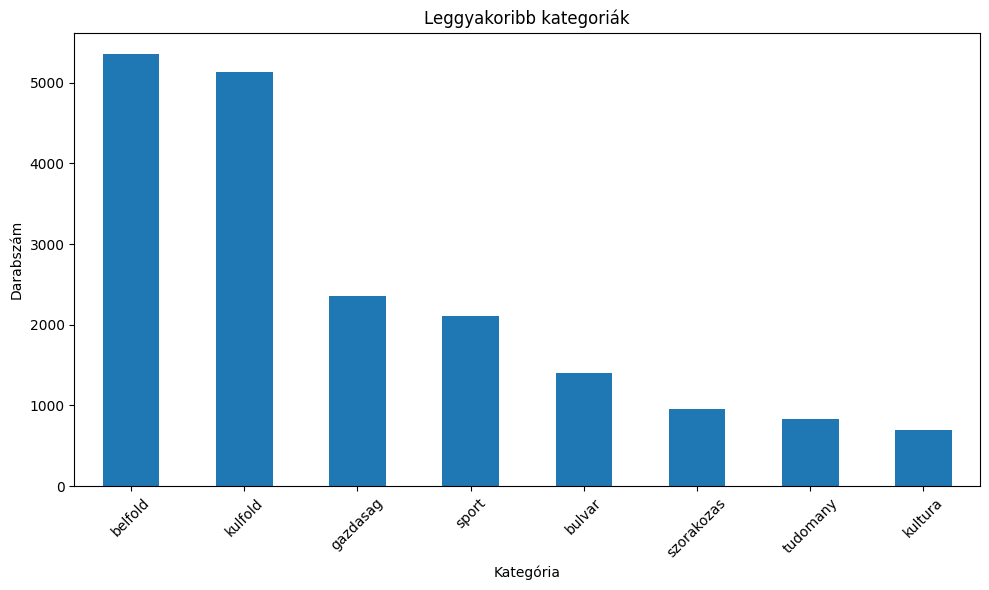

In [91]:
import matplotlib.pyplot as plt

top_categories = df['category'].value_counts().nlargest(20)

plt.figure(figsize=(10, 6))
top_categories.plot(kind='bar')
plt.title('Leggyakoribb kategoriák')
plt.xlabel('Kategória')
plt.ylabel('Darabszám')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [92]:
from bs4 import BeautifulSoup


df['description'] = df['description'].apply(lambda x: BeautifulSoup(str(x), 'html.parser').get_text())

In [93]:
df

,title,description,category
0,Szijjártó Péter az öltözőben gratulált a válog...,"A külügyminiszter elmondta, hatalmas örömet sz...",sport
1,Szilágyi Áron bronzérmes lett a vívó-világbajn...,"Hat tussal is vezetett az elődöntőben, de kika...",sport
2,Ifjuságkutató Intézet: a fiatalok többsége Mag...,A válaszadók kétharmada (68 százalék) tervez 2...,gazdasag
3,A négyszeres világbajnok angol klasszist is ki...,"Köszönetet mondott a helyieknek, hogy megmente...",sport
4,Eltávolították a Twitter feliratot,A rendőrség is megjelent a helyszínen.,kulfold
...,...,...,...
26318,Gömbös Gyula egykori lakóhelyén működik a Part...,Az 1904-ben épült ház gazdag történelemmel ren...,belfold
26320,Ukrán gyerekek háborús naplóit mutatták be Ams...,A háború fájdalmait mutatják be a gyermekek sz...,kulfold
26321,Publicus Intézet: a magyarok negyede azt sem t...,A többséget nem is érdekli a budapesti esemény...,belfold
26322,A kultúra mindig változik,"Száz éve Krúdy, mostanra Krúbi.",belfold


In [94]:
df['text'] = df['title'] + ' ' + df['description']
df.drop(['description', 'title'], axis=1, inplace=True)

In [95]:
import huspacy
import spacy

huspacy.download()
nlp = spacy.load("hu_core_news_lg")



['C:\\Users\\KomPhone\\projects\\ml\\cubix_ml_2\\.venv\\Scripts\\python.exe', '-m', 'pip', 'install', 'hu_core_news_lg @ https://huggingface.co/huspacy/hu_core_news_lg/resolve/v3.8.0/hu_core_news_lg-any-py3-none-any.whl']


In [96]:
import ctypes
import threading


# Rendszer alvásának megakadályozása
ES_CONTINUOUS = 0x80000000
ES_SYSTEM_REQUIRED = 0x00000001
ES_AWAYMODE_REQUIRED = 0x00000040  # csak Windows Media Center óta

def prevent_sleep():
    ctypes.windll.kernel32.SetThreadExecutionState(ES_CONTINUOUS | ES_SYSTEM_REQUIRED)
    threading.Timer(60, prevent_sleep).start()  # 60 másodpercenként újrahívja magát

prevent_sleep()
def lemmatize(text):
    doc = nlp(text.lower())
    return ' '.join(
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    )

df['lemmatized_text'] = df['text'].apply(lemmatize)




In [97]:
df

,category,text,lemmatized_text
0,sport,Szijjártó Péter az öltözőben gratulált a válog...,szijjártó péter öltöző gratulál válogatott ját...
1,sport,Szilágyi Áron bronzérmes lett a vívó-világbajn...,szilágyi ár bronzérmes hat tus vezet elődöntő ...
2,gazdasag,Ifjuságkutató Intézet: a fiatalok többsége Mag...,ifjuságkutató intézet fiatal többség magyarors...
3,sport,A négyszeres világbajnok angol klasszist is ki...,négyszeres világbajnok angol klasszis kiment r...
4,kulfold,Eltávolították a Twitter feliratot A rendőrség...,eltávolít twitter felirat rendőrség megjelenik...
...,...,...,...
26318,belfold,Gömbös Gyula egykori lakóhelyén működik a Part...,gömbös gyula egykori lakóhely működik partizán...
26320,kulfold,Ukrán gyerekek háborús naplóit mutatták be Ams...,ukrán gyerek háborús napló mutat amszterdam há...
26321,belfold,Publicus Intézet: a magyarok negyede azt sem t...,publicus intézet magyar negyed tud hol rendez ...
26322,belfold,"A kultúra mindig változik Száz éve Krúdy, most...",kultúra változik száz év krúdy mostanra krúbi


In [98]:
df.describe()


,category,text,lemmatized_text
count,18839,18839,18839
unique,8,18795,18771
top,belfold,"Már lehet pályázni a CFO of the year díjra, lé...",pályáz cfo of the year díj légy magyarország j...
freq,5352,13,13


In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1, 2))
df['combined'] = df['text'] + ' ' + df['lemmatized_text']
X = vectorizer.fit_transform(df['combined'])

In [134]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['category'])


In [135]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
weight_dict = dict(zip(classes, class_weights))

# Minden sorhoz hozzárendeljük a megfelelő súlyt
sample_weights = np.array([weight_dict[label] for label in y])


In [136]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, stratify=y, random_state=42
)


In [137]:
import optuna
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'n_jobs': -1,
        'verbosity': 0,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_int('gamma', 0, 10)
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, sample_weight=w_train)

    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')


In [138]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)  # 10


[I 2025-06-01 18:14:07,112] A new study created in memory with name: no-name-7846f493-9fb4-4536-b5e8-430acfbaccd7
[I 2025-06-01 18:15:03,796] Trial 0 finished with value: 0.6149834329874653 and parameters: {'n_estimators': 331, 'max_depth': 5, 'learning_rate': 0.15173116445111387, 'subsample': 0.7831329741472648, 'colsample_bytree': 0.9689362720987434, 'gamma': 1}. Best is trial 0 with value: 0.6149834329874653.
[I 2025-06-01 18:15:22,169] Trial 1 finished with value: 0.5909163823768648 and parameters: {'n_estimators': 137, 'max_depth': 8, 'learning_rate': 0.22710898458712978, 'subsample': 0.9523265372117329, 'colsample_bytree': 0.9040254091954724, 'gamma': 6}. Best is trial 0 with value: 0.6149834329874653.


In [105]:
# study.stop()

In [139]:
print("Best trial:")
print("  Value (macro F1):", study.best_value)
print("  Params:", study.best_params)

Best trial:
  Value (macro F1): 0.6149834329874653
  Params: {'n_estimators': 331, 'max_depth': 5, 'learning_rate': 0.15173116445111387, 'subsample': 0.7831329741472648, 'colsample_bytree': 0.9689362720987434, 'gamma': 1}


In [140]:
best_model = XGBClassifier(
    **study.best_params,
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    n_jobs=-1
)

best_model.fit(X_train, y_train, sample_weight=w_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9689362720987434, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15173116445111387,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=331, n_jobs=-1, num_class=8, ...)

In [141]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

     belfold       0.71      0.66      0.68      1071
      bulvar       0.60      0.61      0.61       280
    gazdasag       0.65      0.70      0.67       472
     kulfold       0.80      0.71      0.75      1026
     kultura       0.40      0.47      0.43       139
       sport       0.90      0.88      0.89       423
  szorakozas       0.42      0.53      0.47       192
    tudomany       0.34      0.53      0.41       165

    accuracy                           0.68      3768
   macro avg       0.60      0.64      0.61      3768
weighted avg       0.70      0.68      0.69      3768



In [142]:
import joblib
joblib.dump(best_model, "xgboost_best_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [112]:
def predict_category(text: str) -> str:
    text_clean = (lemmatize(text)).lower()
    X = vectorizer.transform([text_clean])
    pred = best_model.predict(X)
    return le.inverse_transform(pred)[0]


In [132]:
predict_category('Limit, Stop, vagy Piaci? Megbízások, amikkel nem lősz mellé!- online előadás kezdő kereskedőknek')

'kultura'